In [1]:
import sys
import torch
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns


folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

from cnep import CNEP
from cnmp import CNMP

torch.set_float32_matmul_precision('high')

def get_free_gpu():
    gpu_util = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch GPU
#        gpu_util.append((i, torch.cuda.memory_stats()['reserved_bytes.all.current'] / (1024 ** 2)))
        gpu_util.append((i, torch.cuda.utilization()))
    gpu_util.sort(key=lambda x: x[1])
    return gpu_util[0][0]

if torch.cuda.is_available():
    available_gpu = get_free_gpu()
    if available_gpu == 0:
        device = torch.device("cuda:0")
    else:
        device = torch.device(f"cuda:{available_gpu}")
else:
    device = torch.device("cpu")

print("Device :", device)

Device : cuda:0


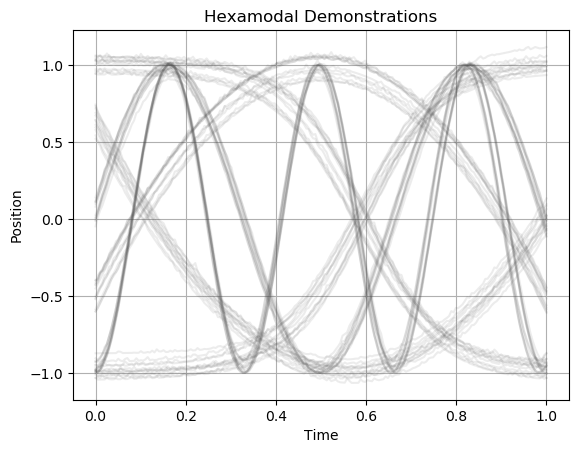

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_modes = 6
num_trajectories_per_mode = 36
t_steps = 200
num_val = 72

# Parameters
num_demos = 384  
num_traj_types = 6
demos_per_type = num_demos // num_traj_types  # 64 demos per trajectory type
num_indiv = num_demos // num_modes
num_val_indiv = num_val // num_modes

# Time steps
x = torch.linspace(0, 1, 200).repeat(num_demos, 1).unsqueeze(-1)

# Output trajectories
y = torch.zeros(num_demos, 200, 1)

vx = torch.linspace(0, 1, 200).repeat(num_val, 1).unsqueeze(-1)
vy = torch.zeros(num_val, 200, 1)

def sin_traj(t, freq, amp, phase, noise_scale=0.025):
    traj = amp * torch.sin(2 * torch.pi * freq * t + phase) + torch.randn(1) * noise_scale
    return traj / torch.max(torch.abs(traj))  # Normalize to [-1, 1]

def cos_traj(t, freq, amp, phase, noise_scale=0.025):
    traj = amp * torch.cos(2 * torch.pi * freq * t + phase) + torch.randn(1) * noise_scale
    return traj / torch.max(torch.abs(traj))

def sigmoid_traj(t, scale, offset, noise_scale=0.025):
    traj = torch.sigmoid(scale * (t - offset)) + torch.randn(1) * noise_scale
    return (traj - 0.5) * 2  # Normalize to [-1, 1]

def rev_sigmoid_traj(t, scale, offset, noise_scale=0.025):
    traj = 1 - torch.sigmoid(scale * (t - offset)) + torch.randn(1) * noise_scale
    return (traj - 0.5) * 2

def u_shaped_traj(t, scale, offset, noise_scale=0.025):
    traj = scale * (t - offset)**2 - 1  # U-shaped with min value at -1
    return traj + torch.randn(1) * noise_scale

def rev_u_shaped_traj(t, scale, offset, noise_scale=0.025):
    traj = -scale * (t - offset)**2 + 1  # Reversed U-shaped with max value at 1
    return traj + torch.randn(1) * noise_scale

# Function Parameters
freq_sin = [1.5, 1.50]
amp_sin = [1, 1]
phases_sin = [0, 0.1]

freq_cos = [3.05, 3.]
amp_cos = [1, 1]
phases_cos = [torch.pi, torch.pi*1.01]

scale_sigmoid = [11, 12]
offset_sigmoid = [0.58, 0.6]

scale_rev_sigmoid = [11, 12]
offset_rev_sigmoid = [0.58, 0.6]

scale_u = [2.57, 2.6]
offset_u = [0.55, 0.57]

scale_rev_u = [2.99, 3.01]
offset_rev_u = [0.495, 0.5]


# Generating Trajectories
for i in range(num_demos):
    traj_type = i // demos_per_type

    if traj_type == 0:
        y[i, :, 0] = sin_traj(x[i, :, 0], freq_sin[i % 2], amp_sin[i % 2], phases_sin[i % 2])
    elif traj_type == 1:
        y[i, :, 0] = cos_traj(x[i, :, 0], freq_cos[i % 2], amp_cos[i % 2], phases_cos[i % 2])
    elif traj_type == 2:
        y[i, :, 0] = sigmoid_traj(x[i, :, 0], scale_sigmoid[i % 2], offset_sigmoid[i % 2])
    elif traj_type == 3:
        y[i, :, 0] = rev_sigmoid_traj(x[i, :, 0], scale_rev_sigmoid[i % 2], offset_rev_sigmoid[i % 2])
    elif traj_type == 4:
        y[i, :, 0] = u_shaped_traj(x[i, :, 0], scale_u[i % 2], offset_u[i % 2]) * 2 + 1
    elif traj_type == 5:
        y[i, :, 0] = rev_u_shaped_traj(x[i, :, 0], scale_rev_u[i % 2], offset_rev_u[i % 2]) *2 -1

for i in range(num_val):
    traj_type = i // num_val_indiv

    noise = torch.unsqueeze(torch.clamp(torch.randn((200))*0.01, min=0), -1)

    if traj_type == 0:
        vy[i, :, 0] = sin_traj(x[i, :, 0], freq_sin[i % 2], amp_sin[i % 2], phases_sin[i % 2])
    elif traj_type == 1:
        vy[i, :, 0] = cos_traj(x[i, :, 0], freq_cos[i % 2], amp_cos[i % 2], phases_cos[i % 2])
    elif traj_type == 2:
        vy[i, :, 0] = sigmoid_traj(x[i, :, 0], scale_sigmoid[i % 2], offset_sigmoid[i % 2])
    elif traj_type == 3:
        vy[i, :, 0] = rev_sigmoid_traj(x[i, :, 0], scale_rev_sigmoid[i % 2], offset_rev_sigmoid[i % 2])
    elif traj_type == 4:
        vy[i, :, 0] = u_shaped_traj(x[i, :, 0], scale_u[i % 2], offset_u[i % 2]) * 2 + 1
    elif traj_type == 5:
        vy[i, :, 0] = rev_u_shaped_traj(x[i, :, 0], scale_rev_u[i % 2], offset_rev_u[i % 2]) *2 -1

    # print(vy[i].shape, noise)
    vy[i] += noise
    
for st in range(72):
    plt.plot(x[st, :, 0], vy[st, :, 0], color='#4d4d4d', alpha=0.1)

# Plot the trajectories
# plt.figure(figsize=(12, 8))
# colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown']

# for j in range(num_modes):
#     for i in range(num_trajectories_per_mode):
#         plt.plot(x, dataset[j * num_trajectories_per_mode + i], alpha=0.3, color=colors[j])

plt.title('Hexamodal Demonstrations')
plt.xlabel('Time')
plt.ylabel('Position')
plt.grid(True)
plt.show()


In [3]:
# Hyperparameters
batch_size = 72
n_max, m_max = 8, 8

t_steps = 200
num_demos = 384
num_classes = 6
num_indiv = num_demos//num_classes  # number of demos per class
dx, dy = 1, 1

colors = [sns.color_palette('tab10')[0], sns.color_palette('tab10')[1], sns.color_palette('tab10')[2], sns.color_palette('tab10')[3]]
sns.set_palette('tab10')

In [4]:
x, y = x.to(device), y.to(device)
print(x.shape, y.shape)

torch.Size([384, 200, 1]) torch.Size([384, 200, 1])


In [5]:
obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
tar_x = torch.zeros((batch_size, m_max, dx), dtype=torch.float32, device=device)
tar_y = torch.zeros((batch_size, m_max, dy), dtype=torch.float32, device=device)
obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)
tar_mask = torch.zeros((batch_size, m_max), dtype=torch.bool, device=device)

def prepare_masked_batch(t: list, traj_ids: list):
    obs.fill_(0)
    tar_x.fill_(0)
    tar_y.fill_(0)
    obs_mask.fill_(False)
    tar_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(1, n_max, (1,)).item()
        m = torch.randint(1, m_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = permuted_ids[n:n+m]
        
        obs[i, :n, :dx] = (n_ids/t_steps).unsqueeze(1)  # X
        obs[i, :n, dx:] = traj[n_ids]  # Y
        obs_mask[i, :n] = True
        
        tar_x[i, :m] = (m_ids/t_steps).unsqueeze(1)
        tar_y[i, :m] = traj[m_ids]
        tar_mask[i, :m] = True

val_obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dx), dtype=torch.float32, device=device)
val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

def prepare_masked_val_batch(t: list, traj_ids: list):
    val_obs.fill_(0)
    val_tar_x.fill_(0)
    val_tar_y.fill_(0)
    val_obs_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(1, n_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = torch.arange(t_steps)
        
        val_obs[i, :n, :dx] = (n_ids/t_steps).unsqueeze(1)
        val_obs[i, :n, dx:] = traj[n_ids]
        val_obs_mask[i, :n] = True
        
        val_tar_x[i] = (m_ids/t_steps).unsqueeze(1)
        val_tar_y[i] = traj[m_ids]

In [6]:
model2_ = CNEP(1, 1, n_max, n_max, [256,256], num_decoders=2, decoder_hidden_dims=[256, 256], batch_size=batch_size, scale_coefs=True, device=device)
optimizer2 = torch.optim.Adam(lr=3e-4, params=model2_.parameters())

model4_ = CNEP(1, 1, n_max, n_max, [256,256], num_decoders=4, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)
optimizer4 = torch.optim.Adam(lr=3e-4, params=model4_.parameters())

model8_ = CNEP(1, 1, n_max, n_max, [256,256], num_decoders=8, decoder_hidden_dims=[64, 64], batch_size=batch_size, scale_coefs=True, device=device)
optimizer8 = torch.optim.Adam(lr=3e-4, params=model8_.parameters())

# cnmp_ = CNMP(1, 1, n_max, m_max, [182,182,182], decoder_hidden_dims=[182,182,182], batch_size=batch_size, device=device)
# optimizer_cnmp = torch.optim.Adam(lr=1e-4, params=cnmp_.parameters())

def get_parameter_count(model):
    total_num = 0
    for param in model.parameters():
        total_num += param.shape.numel()
    return total_num

print("cnep2:", get_parameter_count(model2_))
print("cnep4:", get_parameter_count(model4_))
print("cnep8:", get_parameter_count(model8_))
# print("cnmp:", get_parameter_count(cnmp_))

# if torch.__version__ >= "2.0":
#     model2, model4, model8, cnmp = torch.compile(model2_), torch.compile(model4_), torch.compile(model8_), torch.compile(cnmp_)
# else:
#     model2, model4, model8, cnmp = model2_, model4_, model8_, cnmp_

if torch.__version__ >= "2.0":
    model2, model4, model8 = torch.compile(model2_), torch.compile(model4_), torch.compile(model8_)
else:
    model2, model4, model8 = model2_, model4_, model8_

cnep2: 200198
cnep4: 200716
cnep8: 201752


In [7]:
import time
import os

timestamp = int(time.time())
root_folder = f'../outputs/ablation/hexamodal/2_4_8/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')

if not os.path.exists(f'{root_folder}img/'):
    os.makedirs(f'{root_folder}img/')

torch.save(y, f'{root_folder}y.pt')


epochs = 2_000_000
epoch_iter = num_demos//batch_size  # number of batches per epoch (e.g. 100//32 = 3)
v_epoch_iter = num_val//batch_size  # number of batches per validation (e.g. 100//32 = 3)
avg_loss2, avg_loss4, avg_loss8 = 0, 0, 0

val_per_epoch = 1000
min_vl2, min_vl4, min_vl8 = 1000000, 1000000, 1000000

mse_loss = torch.nn.MSELoss()

for epoch in range(epochs):
    epoch_loss2, epoch_loss4, epoch_loss8 = 0, 0, 0

    traj_ids = torch.randperm(x.shape[0])[:batch_size*epoch_iter].chunk(epoch_iter)  # [:batch_size*epoch_iter] because nof_trajectories may be indivisible by batch_size

    for i in range(epoch_iter):
        prepare_masked_batch(y, traj_ids[i])

        optimizer2.zero_grad()
        pred2, gate2 = model2(obs, tar_x, obs_mask)
        loss2, nll2 = model2.loss(pred2, gate2, tar_y, tar_mask)
        loss2.backward()
        optimizer2.step()


        optimizer4.zero_grad()
        pred4, gate4 = model4(obs, tar_x, obs_mask)
        loss4, nll4 = model4.loss(pred4, gate4, tar_y, tar_mask)
        loss4.backward()
        optimizer4.step()


        optimizer8.zero_grad()
        pred8, gate8 = model8(obs, tar_x, obs_mask)
        loss8, nll8 = model8.loss(pred8, gate8, tar_y, tar_mask)
        loss8.backward()
        optimizer8.step()

        epoch_loss2 += nll2.item()
        epoch_loss4 += nll4.item()
        epoch_loss8 += nll8.item()

    epoch_loss2 = epoch_loss2/epoch_iter
    epoch_loss4 = epoch_loss4/epoch_iter
    epoch_loss8 = epoch_loss8/epoch_iter

    if epoch % val_per_epoch == 0:
        with torch.no_grad():
            v_traj_ids = torch.randperm(vx.shape[0])[:batch_size*v_epoch_iter].chunk(v_epoch_iter)
            val_loss2, val_loss4, val_loss8 = 0, 0, 0

            for j in range(v_epoch_iter):
                prepare_masked_val_batch(vy, v_traj_ids[j])

                p_wta, g_wta = model2.val(val_obs, val_tar_x, val_obs_mask)
                dec_id = torch.argmax(g_wta.squeeze(1), dim=-1)
                vp_means = p_wta[dec_id, torch.arange(batch_size), :, :dy]
                val_loss2 += mse_loss(vp_means, val_tar_y).item()

                p_wta, g_wta = model4.val(val_obs, val_tar_x, val_obs_mask)
                dec_id = torch.argmax(g_wta.squeeze(1), dim=-1)
                vp_means = p_wta[dec_id, torch.arange(batch_size), :, :dy]
                val_loss4 += mse_loss(vp_means, val_tar_y).item()

                p_wta, g_wta = model8.val(val_obs, val_tar_x, val_obs_mask)
                dec_id = torch.argmax(g_wta.squeeze(1), dim=-1)
                vp_means = p_wta[dec_id, torch.arange(batch_size), :, :dy]
                val_loss8 += mse_loss(vp_means, val_tar_y).item()

            if val_loss2 < min_vl2:
                min_vl2 = val_loss2
                print(f'New best 2: {min_vl2}')
                torch.save(model2_.state_dict(), f'{root_folder}saved_models/cnep2.pt')

            if val_loss4 < min_vl4:
                min_vl4 = val_loss4
                print(f'New best 4: {min_vl4}')
                torch.save(model4_.state_dict(), f'{root_folder}saved_models/cnep4.pt')

            if val_loss8 < min_vl8:
                min_vl8 = val_loss8
                print(f'New best 8: {min_vl8}')
                torch.save(model8_.state_dict(), f'{root_folder}saved_models/cnep8.pt')
            
            print(f'Bests: {min_vl2}, {min_vl4}, {min_vl8}')

    avg_loss2 += epoch_loss2
    avg_loss4 += epoch_loss4
    avg_loss8 += epoch_loss8

    if epoch % val_per_epoch == 0:
        print("Epoch: {}, Losses: {}, {}, {}".format(epoch, avg_loss2/val_per_epoch, avg_loss4/val_per_epoch, avg_loss8/val_per_epoch))
        avg_loss2, avg_loss4, avg_loss8 = 0, 0, 0

New best 2: 0.49447470903396606
New best 4: 0.4966186583042145
New best 8: 0.5088673830032349
Bests: 0.49447470903396606, 0.4966186583042145, 0.5088673830032349
Epoch: 0, Losses: 0.0005498884201049805, 0.00027521288990974425, 0.00013868513703346253
New best 2: 0.24330836534500122
New best 4: 0.3233839273452759
New best 8: 0.30384889245033264
Bests: 0.24330836534500122, 0.3233839273452759, 0.30384889245033264
Epoch: 1000, Losses: 0.3754768690168858, 0.2293879017025231, 0.11553844173103571
New best 2: 0.21421357989311218
New best 4: 0.22499462962150574
New best 8: 0.23790676891803741
Bests: 0.21421357989311218, 0.22499462962150574, 0.23790676891803741
Epoch: 2000, Losses: 0.1584445752323547, 0.12854832426426005, 0.07394840064877647
Bests: 0.21421357989311218, 0.22499462962150574, 0.23790676891803741
Epoch: 3000, Losses: 0.0563181649781262, 0.05403900662375172, 0.04257743078826209
New best 2: 0.17284156382083893
New best 4: 0.17516914010047913
New best 8: 0.1852370649576187
Bests: 0.17284

KeyboardInterrupt: 

In [8]:
torch.save(model2_.state_dict(), f'{root_folder}saved_models/last_cnep2.pt')
torch.save(model4_.state_dict(), f'{root_folder}saved_models/last_cnep4.pt')
torch.save(model8_.state_dict(), f'{root_folder}saved_models/last_cnep8.pt')